# 1.dfの作成

In [1]:
import pandas as pd

input = "/Users/macmini/Documents/多目的最適化の理論構築/train/result0.xlsx"
df_all = pd.read_excel(input)

X_cols_SL = ["F14","F15","F16","F20","F0","R14","R15","R16","R20","R0"]
x_cols_hammett = ["Index 14","Index 15","Index 16","Index 20", "Index 0"]
y_cols_m = ["mwave1", "msrength1"]
y_cols_d = ["dwave1", "dstrength1"]

# 2.FPの作成

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

def create_fp_dataframe(df, smiles_col="dimer_smi", radius=2, n_bits=2048):
    """
    DataFrame から指定した SMILES 列を読み込み、Morgan フィンガープリント
    をビットベクトル化して新しい DataFrame として返す。

    Args:
        df (pd.DataFrame): 元の DataFrame（インデックスはそのまま利用）
        smiles_col (str): SMILES が入っているカラム名
        radius (int): Morgan fingerprint の半径
        n_bits (int): フィンガープリント長

    Returns:
        pd.DataFrame: 行数は df と同じ、列は FP_0～FP_{n_bits-1}
    """
    # 1. SMILES リスト取得
    smiles_list = df[smiles_col].tolist()
    
    # 2. フィンガープリント生成
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(np.zeros(n_bits, dtype=int))
            continue
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=int)
        DataStructs.ConvertToNumpyArray(bv, arr)
        fps.append(arr)
    
    # 3. ndarray 化＆DataFrame 化
    fps_array = np.vstack(fps)  # shape = (len(df), n_bits)
    col_names = [f"FP_{i}" for i in range(n_bits)]
    df_fp = pd.DataFrame(fps_array, columns=col_names, index=df.index)
    
    return df_fp

# 使い方例

df_fp = create_fp_dataframe(df_all, smiles_col="dimer_smi", radius=2, n_bits=2048)
print(df_fp.shape)
df_fp.head()

# csv化
output_fp = "fp.csv"
df_fp.to_csv(output_fp, index=False)


(256, 2048)


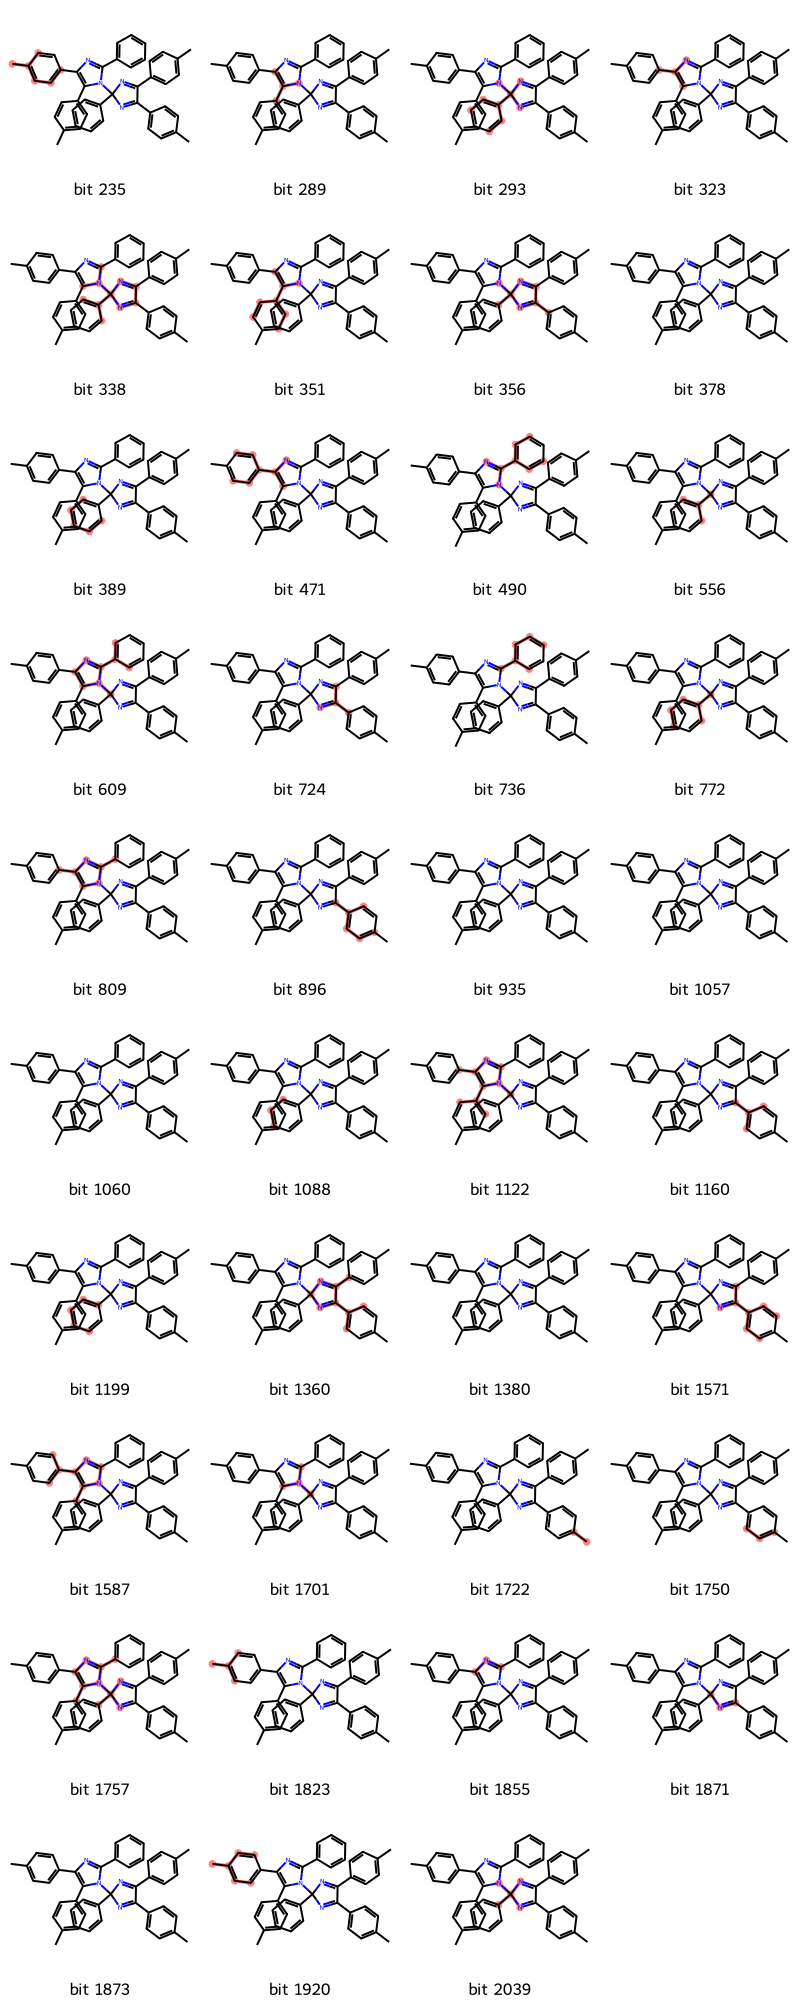

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

def visualize_fp_substructures(df, smiles_col="dimer_smi",
                               radius=2, n_bits=2048, num_bits=8,
                               mols_per_row=4, subimg_size=(200,200)):
    """
    df の最初の SMILES について、フィンガープリントの
    上位 num_bits ビットに対応する原子環境をハイライト表示。
    PIL Image を直接表示します。
    """
    # 1) 分子取得
    smi = df.iloc[100][smiles_col]
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        raise ValueError("Invalid SMILES in first row")

    # 2) フィンガープリントと bitInfo
    bitInfo = {}
    _ = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, bitInfo=bitInfo)

    # 3) 上位 num_bits オンビット
    on_bits = list(bitInfo.keys())[:num_bits]

    # 4) ハイライト原子リスト作成
    highlight_lists = []
    legends = []
    for bit in on_bits:
        envs = bitInfo[bit]
        if not envs:
            highlight_lists.append([])
            legends.append(f"bit {bit}: none")
        else:
            atom_idx, rad = envs[0]
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
            amap = {}
            _ = Chem.PathToSubmol(mol, env, atomMap=amap)
            highlight_lists.append(list(amap.keys()))
            legends.append(f"bit {bit}")

    # 5) PIL Image を生成
    pil_img = Draw.MolsToGridImage(
        [mol] * len(highlight_lists),
        molsPerRow=mols_per_row,
        subImgSize=subimg_size,
        highlightAtomLists=highlight_lists,
        legends=legends
    )

    # 6) 直接表示
    display(pil_img)

# 使用例
visualize_fp_substructures(df_all, smiles_col="dimer_smi", radius=2, n_bits=2048, num_bits=100)


In [5]:
df_all_FP = pd.concat([df_all, df_fp], axis=1)

# 3.小規模探索検証

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2
from tqdm import trange, tqdm
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    """
    L2-Lower Confidence Bound for multi-output GP via exact non-central chi-square.
    """
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    lam = diff2 / gamma2
    q = ncx2.ppf(1 - p, df=k, nc=lam)
    q = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    # print(f"p: {p}, k: {k}, gamma2: {gamma2.mean()}, diff2: {diff2.mean()}, lam: {lam.mean()}, q: {q.mean()}")
    return - q * gamma2

def l2_lcb_per_dim(means: np.ndarray,
                   variances: np.ndarray,
                   target: np.ndarray,
                   p: float = 0.05,
                   eps: float = 1e-8) -> np.ndarray:

    # 1) prevent zero variances
    vars_safe = np.maximum(variances, eps)
    # 2) compute non-centrality λ for each candidate
    lam = np.sum((means - target)**2 / vars_safe, axis=1)
    # 3) inverse survival function: P(X ≥ q) = p for χ²ₖ(λ)
    q   = ncx2.isf(p, df=means.shape[1], nc=lam)
    # 4) score = −q (we pick argmax scores ⇒ minimize q)
    return -q


def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    """
    L2-Expected Improvement for multi-output GP via non-central chi-square.
    """
    k = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2 = np.sum((means - target)**2, axis=1)
    nc = diff2 / gamma2
    x = y_min / gamma2
    t1 = y_min * ncx2.cdf(x, df=k, nc=nc)
    t2 = gamma2 * (
        k   * ncx2.cdf(x, df=k+2, nc=nc)
      + nc  * ncx2.cdf(x, df=k+4, nc=nc)
    )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    """各出力次元ごとに GPy の GPRegression をフィッティングしてリストで返す。"""
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=False)
        m = GPy.models.GPRegression(X, Y[:, [i]], kern)
        # m.Gaussian_noise.variance = 1e-6
        # m.Gaussian_noise.variance.fix()
        m.optimize(messages=False,max_iters=5)
        models.append(m)
        # print(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    """リスト化した GPRegression モデル群で予測し、平均と分散の配列を返す。"""
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def export_sorted_distances_to_csv(Y: np.ndarray,
                                   target: np.ndarray,
                                   filename: str = "/Users/macmini/Documents/distances_to_target.csv"):
    """
    全候補点 Y と target のユークリッド距離を計算し、
    距離が小さい順にソートした結果を CSV に書き出す。
    """
    dists = np.linalg.norm(Y - target.reshape(1, -1), axis=1)
    order = np.argsort(dists)
    df_out = pd.DataFrame({
        "index": order,
        "distance": dists[order]
    })
    df_out.to_csv(filename, index=False)
    print(f"Sorted distances saved to {filename}")



In [181]:
def compare_all_methods(df, X_cols, Y_cols, target,
                        methods=('lcb','ei','rand'),
                        init_size=5, trials=50, p=0.05, budget=None):
    """
    1回のBOサイクルで以下すべてを同時に記録：
      - df_hits:  各手法の反復ごとの5%発見割合
      - df_regret:各手法・各目的関数の反復ごとの累積後悔
      - df_picks: 各手法・各試行の反復ごとの選択インデックス
      - df_Y:     各手法・各目的関数の反復ごとの実際のY値
      - df_acq:   各手法の反復ごとの選択された獲得関数値の平均
    """
    X_all = df[X_cols].values
    Y_all = df[Y_cols].values
    N     = len(df)
    if budget is None:
        budget = N - init_size
    n_obj = len(Y_cols)
    top_n = int(np.ceil(N * 0.05))

    # “真”の top-5% インデックス
    scaler_g  = StandardScaler().fit(Y_all)
    Y_s_all   = scaler_g.transform(Y_all)
    t_s_all   = scaler_g.transform(target.reshape(1,-1)).flatten()
    top_idx   = set(np.argsort(np.linalg.norm(Y_s_all - t_s_all, axis=1))[:top_n])

    # 結果格納用
    hit_hist    = {m: np.zeros((trials, budget))         for m in methods}
    regret_hist = {m: np.zeros((trials, budget, n_obj))  for m in methods}
    picks_idx   = {m: np.zeros((trials, budget), dtype=int) for m in methods}
    picks_Y     = {m: np.zeros((trials, budget, n_obj))  for m in methods}
    acq_hist    = {m: np.zeros((trials, budget))         for m in methods}

    # trials × iterations ループ
    for run in trange(trials, desc="Trials"):
        rng  = np.random.RandomState(run+1)
        perm = rng.permutation(N)
        train_base = perm[:init_size].tolist()
        cand_base  = perm[init_size:].tolist()

        for m in methods:
            train_idx = train_base.copy()
            cand_idx  = cand_base.copy()
            cum_hits  = sum(i in top_idx for i in train_idx)
            cum_reg   = np.zeros(n_obj)

            # 初期モデル (LCB/EI の場合)
            if m in ('lcb','ei'):
                X_tr   = X_all[train_idx]
                Y_tr   = Y_all[train_idx]
                sc     = StandardScaler().fit(Y_tr)
                Y_tr_s = sc.transform(Y_tr)
                t_s    = sc.transform(target.reshape(1,-1)).flatten()
                models = fit_multi_gpy(X_tr, Y_tr_s)

            for it in range(budget):
                X_cd = X_all[cand_idx]

                # ——— 獲得関数の計算 ———
                if m == 'lcb':
                    mu, var = predict_multi_gpy(models, X_cd)
                    scores  = l2_lcb_per_dim(mu, var, t_s, p)
                elif m == 'ei':
                    mu, var = predict_multi_gpy(models, X_cd)
                    y_min   = np.min(np.sum((Y_tr_s - t_s)**2, axis=1))
                    scores  = l2_ei(mu, var, t_s, y_min)
                else:  # rand
                    scores = None

                # ——— pick と獲得関数値の記録 ———
                if scores is not None:
                    pick = np.argmax(scores)
                    acq_hist[m][run, it] = scores[pick]
                else:
                    pick = rng.randint(len(cand_idx))
                    acq_hist[m][run, it] = np.nan

                idx_pick = cand_idx.pop(pick)
                train_idx.append(idx_pick)

                # 1) 5%ヒット率
                if idx_pick in top_idx:
                    cum_hits += 1
                hit_hist[m][run, it] = cum_hits / top_n

                # 2) 累積後悔
                y_new = Y_all[idx_pick]
                cum_reg += np.abs(y_new - target)
                regret_hist[m][run, it, :] = cum_reg

                # 3) 選択インデックス・Y値
                picks_idx[m][run, it] = idx_pick
                picks_Y[m][run, it, :] = y_new

                # モデル更新 (LCB/EI)
                if m in ('lcb','ei'):
                    X_tr   = X_all[train_idx]
                    Y_tr   = Y_all[train_idx]
                    sc     = StandardScaler().fit(Y_tr)
                    Y_tr_s = sc.transform(Y_tr)
                    t_s    = sc.transform(target.reshape(1,-1)).flatten()
                    for obj_idx, mdl in enumerate(models):
                        # Y_tr_s[:, [obj_idx]] の shape は (n_train,1)
                        mdl.set_XY(X_tr, Y_tr_s[:, [obj_idx]])
                        mdl.optimize(messages=False, max_iters=5)
                        # print(mdl)

    # DataFrame 化
    df_hits = pd.DataFrame(
        {m: hit_hist[m].mean(axis=0) for m in methods},
        index=np.arange(1, budget+1))
    df_hits.index.name = 'iteration'

    df_regret = {
        m: pd.DataFrame(
             regret_hist[m].mean(axis=0),
             columns=Y_cols,
             index=np.arange(1, budget+1)
           )
        for m in methods
    }

    df_picks = {
        m: pd.DataFrame(
             picks_idx[m],
             index=[f"run{r+1}" for r in range(trials)],
             columns=[f"iter{t+1}" for t in range(budget)]
           )
        for m in methods
    }

    df_Y = {
        m: {
            col: pd.DataFrame(
                     picks_Y[m][:, :, i],
                     index=[f"run{r+1}" for r in range(trials)],
                     columns=[f"iter{t+1}" for t in range(budget)]
                 )
            for i, col in enumerate(Y_cols)
        }
        for m in methods
    }

    df_acq = pd.DataFrame(
        {m: acq_hist[m].mean(axis=0) for m in methods},
        index=np.arange(1, budget+1))
    df_acq.index.name = 'iteration'

    return df_hits, df_regret, df_picks, df_Y, df_acq



# --- プロット関数 ---

def plot_hits(df_hits):
    plt.figure(figsize=(8,5))
    for m in df_hits.columns:
        plt.plot(df_hits.index, df_hits[m], label=m.upper())
    plt.xlabel("Iteration")
    plt.ylabel("Fraction of Top-5% Found")
    plt.title("5% Discovery Fraction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_avg_target_regret_per_objective(df_regret: dict,
                                         methods: list,
                                         Y_cols: list):
    """
    df_regret: compare_all_methods が返す
               { method: DataFrame(iteration × objectives) }
    methods:   ['lcb','ei','rand'] など
    Y_cols:    目的関数カラムのリスト
    """
    for col in Y_cols:
        plt.figure(figsize=(8,5))
        for m in methods:
            df_m = df_regret[m]
            # 平均ターゲット後悔 = 累積後悔 / iteration
            avg_regret = df_m[col] / df_m.index
            plt.plot(df_m.index, avg_regret, label=m.upper())
        plt.title(f"Average Target Regret per Iteration ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def plot_acquisition(df_acq):
    """
    df_acq: compare_all_methods が返す
            DataFrame(iteration × methods) — 各反復で選ばれた獲得関数値の平均
    """
    plt.figure(figsize=(8,5))
    for m in df_acq.columns:
        plt.plot(df_acq.index, df_acq[m], label=m.upper())
    plt.xlabel("Iteration") 
    plt.ylabel("Acquisition Value")
    plt.title("Mean Chosen Acquisition Value per Iteration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [55]:
# X_cols_FP = [f"FP_{i}" for i in range(2048)]
# for i, v in enumerate(X_cols_FP):
#     print(f"{i:3d}: {v}")


# df_FPの0しかないカラムを抜く
df_FP_NONE0 = df_fp.loc[:, (df_fp != 0).any(axis=0)]
X_cols_FP_NONE0 = df_FP_NONE0.columns.tolist()
print(f"FP columns with non-zero values: {len(X_cols_FP_NONE0)}")

# df_FPの1しかないカラムを抜く
df_FP_NONE1 = df_fp.loc[:, (df_fp != 1).any(axis=0)]
X_cols_FP_NONE1 = df_FP_NONE1.columns.tolist()
print(f"FP columns with non-one values: {len(X_cols_FP_NONE1)}")


FP columns with non-zero values: 213
FP columns with non-one values: 2024


# FPでのBO


In [190]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, X_cols_FP_NONE0 , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=5, trials=50, p=0.9, budget=251
)



Trials: 100%|██████████| 50/50 [24:39<00:00, 29.59s/it]


In [191]:
# ファイルの保存
file_initial = "/Users/macmini/BO_result/initsize5_LCB_per_dim_p_0.9/FP/FP_BO_resultsFP_p_0.7_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# SLでのBO

In [136]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, X_cols_SL , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=5, trials=200, p=0.7, budget=251
)

Trials: 100%|██████████| 200/200 [2:57:43<00:00, 53.32s/it]  


In [ ]:
# ファイルの保存
file_initial = "/Users/macmini/BO_result/inimax5_remax5_t200/SL/SL_p_0.7_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# HammettでのBO

In [193]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, x_cols_hammett , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=5, trials=50, p=0.7, budget=251
)


Trials: 100%|██████████| 50/50 [20:17<00:00, 24.35s/it]


In [194]:
# ファイルの保存
file_initial = "/Users/macmini/BO_result/initsize5_LCB_per_dim_p_0.9/Hammett/Hammett_p_0.7_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# FP_p=0.9

In [58]:
target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, X_cols_FP_NONE0 , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=5, trials=50, p=0.9, budget=251
)

Trials: 100%|██████████| 50/50 [29:12<00:00, 35.05s/it]


In [59]:
# ファイルの保存
file_initial = "/Users/macmini/BO_result/FP_0.9_BO_results/FP_p_0.9_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

#   FP_p=0.1

In [73]:
target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, X_cols_FP_NONE0 , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=5, trials=50, p=0.1, budget=251
)

Trials: 100%|██████████| 50/50 [29:15<00:00, 35.12s/it]


In [100]:
# ファイルの保存
file_initial = "/Users/macmini/BO_result/FP_0.1_BO_results/FP_p_0.1_init5"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# FP初期点50

In [144]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, X_cols_FP_NONE0 , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=50, trials=50, p=0.7, budget=None
)


Trials: 100%|██████████| 50/50 [23:46<00:00, 28.52s/it]


In [145]:
# ファイルの保存
file_initial = "/Users/macmini/BO_result/initmax100_remax_5/FP/FP_p_0.7_init50"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# Hammett初期点50


In [147]:
# 入力：pandas.DataFrame df_all, 説明変数カラム X_cols, 目的変数カラム Y_cols, 目標ベクトル target, 初期サイズ init_size

target = np.array([530.64 , 0.005])  # 目標ベクトルを適宜設定
df_hits, df_regret, df_picks, df_Y, df_acq = compare_all_methods(
    df_all_FP, x_cols_hammett , y_cols_d, target,
    methods=('lcb','ei','rand'),
    init_size=50, trials=50, p=0.7, budget=None
)

Trials: 100%|██████████| 50/50 [19:25<00:00, 23.31s/it]


In [148]:
# ファイルの保存
file_initial = "/Users/macmini/BO_result/initmax100_remax_5/Hammett/Hammett_p_0.7_init50"
df_hits.to_csv(f"{file_initial}_hits.csv")
df_regret_lcb = df_regret['lcb']
df_regret_ei = df_regret['ei']
df_regret_rand = df_regret['rand']
df_regret_lcb.to_csv(f"{file_initial}_regret_lcb.csv")
df_regret_ei.to_csv(f"{file_initial}_regret_ei.csv")
df_regret_rand.to_csv(f"{file_initial}_regret_rand.csv")

df_picks_lcb = df_picks['lcb']
df_picks_ei = df_picks['ei']
df_picks_rand = df_picks['rand']
df_picks_lcb.to_csv(f"{file_initial}_picks_lcb.csv")
df_picks_ei.to_csv(f"{file_initial}_picks_ei.csv")
df_picks_rand.to_csv(f"{file_initial}_picks_rand.csv")

df_Y_lcb = df_Y['lcb']
df_Y_ei = df_Y['ei']
df_Y_rand = df_Y['rand']
df_Y_lcb = pd.concat(df_Y_lcb, axis=1)
df_Y_ei = pd.concat(df_Y_ei, axis=1)
df_Y_rand = pd.concat(df_Y_rand, axis=1)
df_Y_lcb.to_csv(f"{file_initial}_Y_lcb.csv")
df_Y_ei.to_csv(f"{file_initial}_Y_ei.csv")
df_Y_rand.to_csv(f"{file_initial}_Y_rand.csv")

df_acq.to_csv(f"{file_initial}_acq.csv")

# 可視化

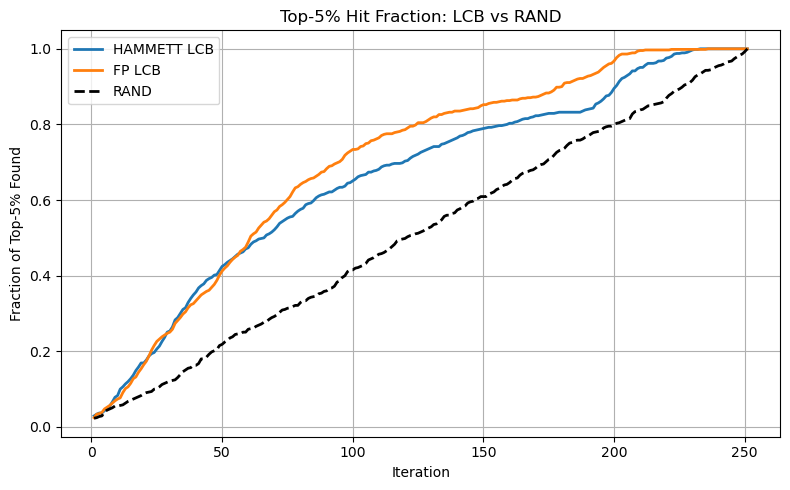

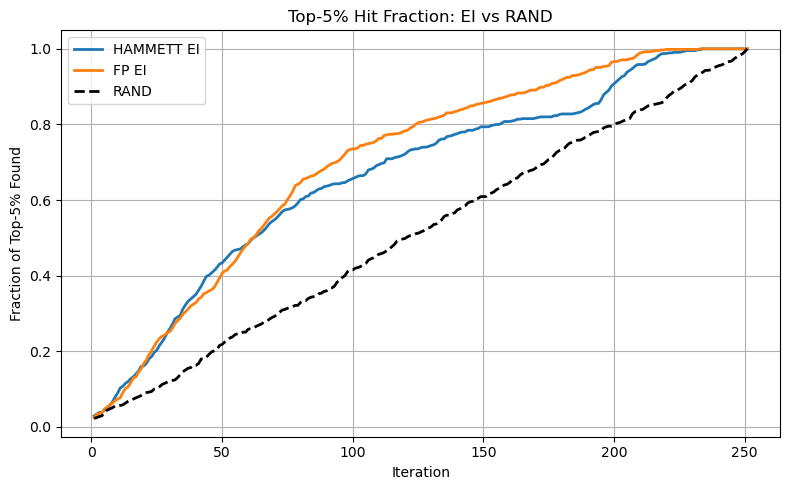

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_results(file_initials, metrics=('hits', 'regret', 'acq')):
    """
    file_initials: dict mapping descriptor names to the base filepath (without suffix)
                   e.g. {'FP': '/path/Hammett_fp', 'SL': '/path/Hammett_sl'}
    metrics:       tuple of metrics to load; supported: 'hits', 'regret', 'acq'
    returns:       dict of dicts: results[metric][descriptor] = DataFrame
    """
    results = {m: {} for m in metrics}
    for desc, base in file_initials.items():
        for m in metrics:
            fname = f"{base}_{m}.csv"
            if os.path.isfile(fname):
                df = pd.read_csv(fname, index_col=0)
                results[m][desc] = df
            else:
                print(f"Warning: file not found: {fname}")
    return results

def plot_hits_comparison(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor names to df_hits DataFrames
    """
    plt.figure(figsize=(8, 5))
    for desc, df in df_hits_dict.items():
        plt.plot(df.index, df.iloc[:, 0], label=desc)  # assumes single column or first column
    plt.xlabel("Iteration")
    plt.ylabel("Fraction of Top-5% Found")
    plt.title("Comparison of 5% Discovery Fraction Across Descriptors")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_acq_comparison(df_acq_dict):
    """
    df_acq_dict: dict mapping descriptor names to df_acq DataFrames
    """
    plt.figure(figsize=(8, 5))
    for desc, df in df_acq_dict.items():
        plt.plot(df.index, df.iloc[:, 0], label=desc)  # first acquisition method
    plt.xlabel("Iteration")
    plt.ylabel("Mean Acquisition Value")
    plt.title("Comparison of Acquisition Values Across Descriptors")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_regret_comparison(df_regret_dict):
    """
    df_regret_dict: dict mapping descriptor names to df_regret dicts
                    where df_regret_dict[desc] is a dict mapping method to DataFrame
    """
    for desc, methods_dict in df_regret_dict.items():
        for method, df in methods_dict.items():
            plt.figure(figsize=(6, 4))
            # plot sum or average over objectives
            avg_regret = df.mean(axis=1)
            plt.plot(df.index, avg_regret, label=f"{desc}-{method}")
            plt.xlabel("Iteration")
            plt.ylabel("Average Cumulative Regret")
            plt.title(f"{desc} - {method.upper()} Regret")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

import matplotlib.pyplot as plt

def plot_hits_by_method(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor names → DataFrame with columns ['lcb','ei','rand']
                  index が iteration
    例: {'FP': df_fp_hits, 'SL': df_sl_hits, 'Hammett': df_h_hits}
    """
    # まずメソッド一覧を取得
    methods = df_hits_dict[next(iter(df_hits_dict))].columns.tolist()
    
    for m in methods:
        plt.figure(figsize=(8,5))
        for desc, df in df_hits_dict.items():
            plt.plot(df.index, df[m], label=desc)
        plt.title(f"Top-5% Hit Fraction per Iteration ({m.upper()})")
        plt.xlabel("Iteration")
        plt.ylabel("Fraction of Top-5% Found")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def plot_hits_with_random_baseline(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor → DataFrame with columns ['lcb','ei','rand']
    各 descriptor ごとに、
      ・lcb vs rand
      ・ei  vs rand
    を同じグラフ上で比較します。
    """
    methods = ['lcb','ei']
    for m in methods:
        plt.figure(figsize=(8,5))
        for desc, df in df_hits_dict.items():
            # メインの獲得関数
            plt.plot(df.index, df[m],
                     label=f"{desc.upper()} {m.upper()}", linewidth=2)
            # ランダムベースライン
            plt.plot(df.index, df['rand'],
                     linestyle='--',
                     label=f"{desc.upper()} RAND")
        plt.title(f"Top-5% Hit Fraction: {m.upper()} vs RAND")
        plt.xlabel("Iteration")
        plt.ylabel("Fraction of Top-5% Found")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_hits_with_single_random(df_hits_dict):
    """
    df_hits_dict: dict mapping descriptor -> DataFrame with columns ['lcb','ei','rand']
    各メソッド（lcb, ei）ごとに、説明関数別の曲線と
    ランダム平均（RAND）を一つだけ重ねてプロットします。
    """
    # すべての descriptor から RAND 列の平均を計算
    any_desc = next(iter(df_hits_dict))
    iterations = df_hits_dict[any_desc].index.values
    rand_values = np.mean(
        [df['rand'].values for df in df_hits_dict.values()],
        axis=0
    )

    for m in ['lcb', 'ei']:
        plt.figure(figsize=(8,5))
        # 各説明関数の曲線
        for desc, df in df_hits_dict.items():
            plt.plot(
                df.index, df[m],
                label=f"{desc.upper()} {m.upper()}",
                linewidth=2
            )
        # ランダム平均を一度だけプロット
        plt.plot(
            iterations, rand_values,
            linestyle='--', color='black',
            label='RAND', linewidth=2
        )
        plt.title(f"Top-5% Hit Fraction: {m.upper()} vs RAND")
        plt.xlabel("Iteration")
        plt.ylabel("Fraction of Top-5% Found")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- 使用例 ---
# results = load_results(file_initials, metrics=('hits','acq','regret'))
# plot_hits_with_single_random(results['hits'])



# --- Example usage ---
# 1) 検証した説明関数のベースファイル名を辞書で指定
file_initials = {
    'Hammett': "../BO_result/initmax5_remax_5/Hammett/Hammett_p_0.7_init5",
    # 'SL': '/Users/macmini/BO_result/inimax5_remaxunlimited_t200/SL/SL_p_0.7_init5',
    'FP': "../BO_result/initmax5_remax_5/FP/FP_BO_resultsFP_p_0.7_init5"
    # 他の説明関数も同様に追加
}

# 2) データ読み込み
results = load_results(file_initials, metrics=('hits', 'acq', 'regret'))

# 3) 比較プロット
plot_hits_with_single_random(results['hits'])

file_initials_init50 = {
    'Hammett':"/Users/macmini/BO_result/initmax100_remax_5/Hammett/Hammett_p_0.7_init50",
    'FP': "/Users/macmini/BO_result/initmax100_remax_5/FP/FP_p_0.7_init50"
}

results_init50 = load_results(file_initials_init50, metrics=('hits', 'acq', 'regret'))
# plot_hits_with_single_random(results_init50['hits'])
 


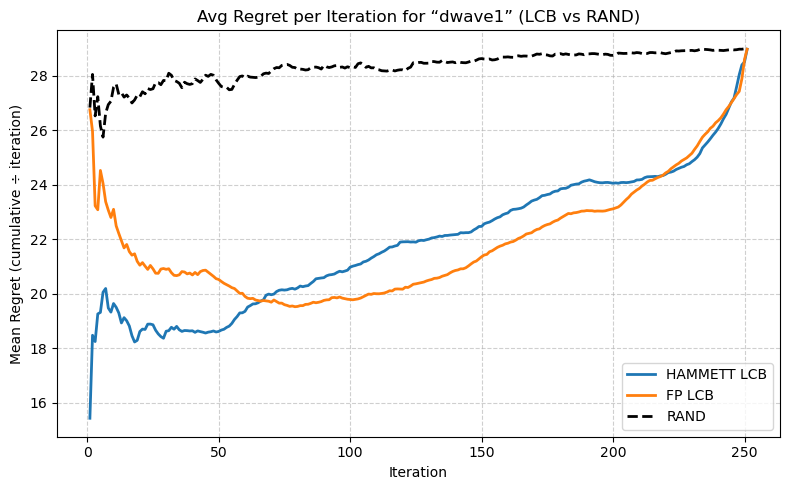

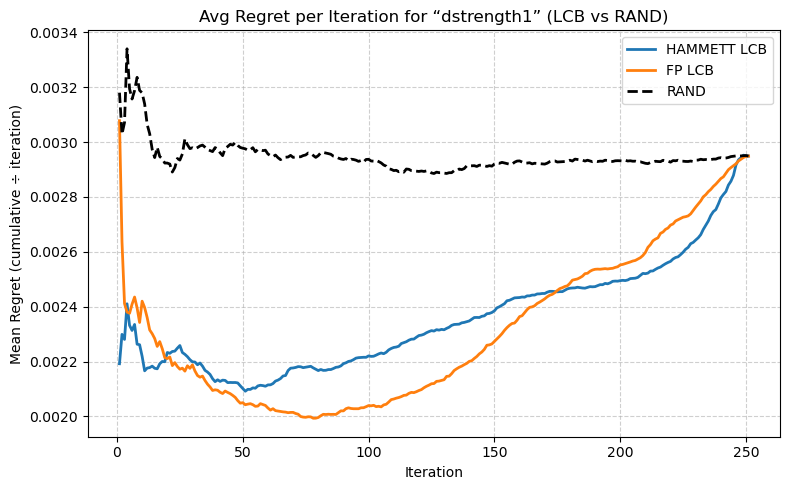

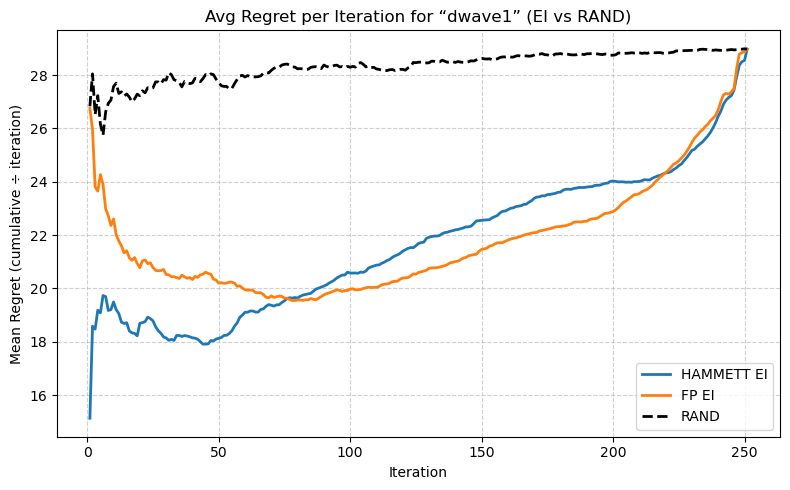

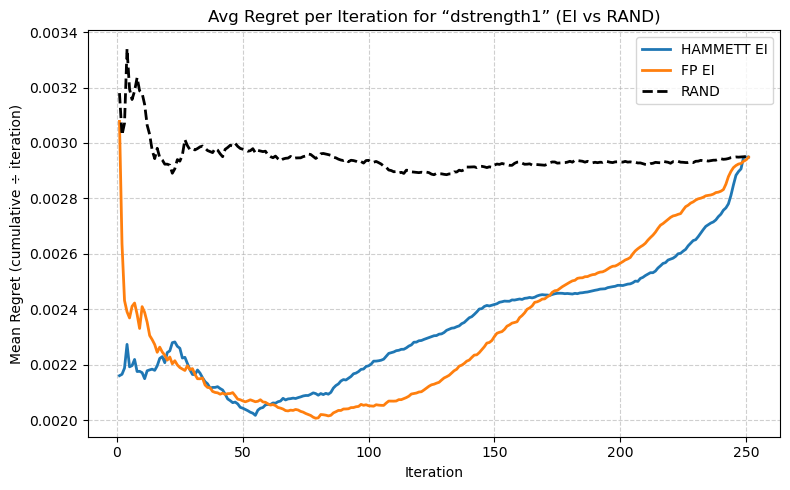

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_regret_by_method(file_initials, methods=('lcb','ei','rand')):
    """
    file_initials: dict mapping descriptor names to base file paths (without suffix)
    methods: tuple of acquisition methods
    returns: dict mapping method -> dict mapping descriptor -> DataFrame
    """
    results = {m: {} for m in methods}
    for desc, base in file_initials.items():
        for m in methods:
            fname = f"{base}_regret_{m}.csv"
            if os.path.isfile(fname):
                df = pd.read_csv(fname, index_col=0)
                results[m][desc] = df
            else:
                print(f"Warning: file not found: {fname}")
    return results
       
def plot_avg_regret_per_obj_with_rand(regret_results):
    """
    各獲得関数 (lcb, ei) × 各目的関数ごとに、
    各説明関数の平均後悔（累積後悔÷iteration）と
    RAND の平均後悔を同じグラフに表示します。

    Parameters
    ----------
    regret_results : dict
        load_regret_by_method の出力形式
        {'lcb': {'FP': df, ...},
         'ei':  {...},
         'rand': {...}}
    """
    rand_dict = regret_results['rand']
    # RAND の各目的関数ごとの平均累積後悔を計算
    # 目的関数一覧取得
    sample_rand_df = next(iter(rand_dict.values()))
    objectives = sample_rand_df.columns.tolist()

    # RAND 平均累積後悔DFを作成
    rand_avg_cum = pd.DataFrame(
        {desc: df[obj] for desc, df in rand_dict.items() for obj in objectives},
        index=sample_rand_df.index
    )
    # Actually, better to compute per objective:
    rand_avg_cum = pd.DataFrame({
        obj: pd.concat([df[obj] for df in rand_dict.values()], axis=1).mean(axis=1)
        for obj in objectives
    })
    
    for method in ['lcb', 'ei']:
        method_dict = regret_results[method]
        for obj in objectives:
            plt.figure(figsize=(8, 5))
            # 各説明関数
            for desc, df in method_dict.items():
                avg_regret = df[obj] / df.index
                plt.plot(df.index, avg_regret,
                         label=f"{desc.upper()} {method.upper()}",
                         linewidth=2)
            # RAND baseline
            rand_avg = rand_avg_cum[obj] / rand_avg_cum.index
            plt.plot(rand_avg.index, rand_avg.values,
                     linestyle='--', color='black', label='RAND', linewidth=2)
            
            plt.title(f"Avg Regret per Iteration for “{obj}” ({method.upper()} vs RAND)")
            plt.xlabel("Iteration")
            plt.ylabel("Mean Regret (cumulative ÷ iteration)")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()



regret_by_method = load_regret_by_method(file_initials)
# plot_regret_by_method(regret_by_method)
# plot_avg_regret_per_iter_by_method(regret_by_method)
# plot_avg_regret_per_obj_by_method(regret_by_method)
# plot_avg_regret_with_rand(regret_by_method)
plot_avg_regret_per_obj_with_rand(regret_by_method)